<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>EDA & Preprocessing
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Vorgegebenes Ziel

Wir evaluieren 3 verschiedene Klassifikationssysteme in einer Textklassifikationsaufgabe. <br><br>
Wir argumentieren, warum wir diese Systeme für diesen Fall ausgewählt haben, und bauen, trainieren und bewerten das System. <br><br>
Wir führen auch eine gründliche Fehleranalyse durch und schlagen Theorien zur Verbesserung der Systeme vor, <br>
insbesondere durch die Analyse einzelner Fälle und den Vergleich der Vorhersagen jedes Systems. <br>
Mindestens eines der Systeme basiert auf einem feinabgestimmten Deep-Learning-Modell.

Hier können wir Daten aus gemeinsamen Aufgaben verwenden, wie zum Beispiel Semeval, Kaggle, <br>Codalab oder Paperwithcode für die Textklassifikation.

## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [1]:
# All Imports
import sys
import torch
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")

# Warnings Settings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (24, 12)

Python Version: 3.10.12 (main, Jun 20 2023, 19:43:52) [Clang 14.0.3 (clang-1403.0.22.14.1)]
PyTorch Version: 2.0.1
Numpy Version: 1.23.5
Pandas Version: 1.5.3
Matplotlib Version: 3.6.3
Sklearn Version: 1.3.1
Seaborn Version: 0.12.2


## Helper Functions

Hier werden Funktionen definiert, die bei beiden Modellen verwendet werden.

In [2]:
# Metrics, shortcuts, constants, etc.

## Gewählter Datensatz

Wir haben uns für den <a href="https://www.kaggle.com/competitions/nlp-getting-started/data">"Natural Language Processing with Disaster Tweets"</a> Datensatz entschieden.<br><br>
Der Datensatz passt zum Ziel der Mini Challenge, da er Textdaten aus Twitter enthält, die in Notfällen <br>als wichtiger Kommunikationskanal dienen. Dies ermöglicht die Entwicklung und Evaluierung von <br>Textklassifikationssystemen, um Tweets zu identifizieren, die echte Katastrophen ankündigen, <br>von solchen, die dies nicht tun. <br><br>Dies erfordert eine gründliche Fehleranalyse und die Entwicklung von Modellen, die in der Lage sind, <br>die Bedeutung von Wörtern und Ausdrücken im Kontext zu verstehen, da Tweets oft metaphorische <br>Sprache verwenden können. <br><br>Wir haben Zugriff auf einen Datensatz von 10.000 handklassifizierten Tweets, der eine solide <br>Grundlage für die Evaluierung und Verbesserung von Textklassifikationssystemen bietet.

## Explorative Datenanalyse

In [3]:
tweets = pd.read_csv("./data/train.csv", index_col="id", encoding="utf-8")
tweets.columns

Index(['keyword', 'location', 'text', 'target'], dtype='object')

Der Datensatz hat zum Text und dem Target noch die Spalten Keyword und Location. Diese werden wir für die Klassifikation nicht verwenden. Ein hybrides Modell könnte die Vorhersage verbessern.

In [4]:
tweets = tweets.loc[:,["text","target"]]

Im nächsten Schritt wird ein Trainings- und Testset erstellt. Dies wird zu diesem Zeitpunkt gemacht, damit wir keine Informationen über das Testset gewinnen.

In [5]:
train, test = train_test_split(tweets, test_size=0.2,random_state=10)

Im nächsten Schritt wird untersucht, ob es unbekannte oder doppelte Werte hat. 

In [6]:
print(f"Anzahl NA Werte: {train.isna().any().sum()}")
print(f"Anzahl doppelte Werte: {train['text'].duplicated().sum()}")

Anzahl NA Werte: 0
Anzahl doppelte Werte: 77


Es hat keine NA Werte, aber diverse doppelte Werte. Im nächsten Schritt wird untersucht, ob alle doppelten Werte den gleichen Target Wert hat.

In [7]:
tweets[tweets["text"].duplicated() &  (tweets.duplicated() == False)]

,text,target
id,,
898,To fight bioterrorism sir.,0
1922,Mmmmmm I'm burning.... I'm burning buildings I...,0
1950,like for the music video I want some real acti...,0
1968,I Pledge Allegiance To The P.O.P.E. And The Bu...,1
4076,.POTUS #StrategicPatience is a strategy for #G...,0
4659,He came to a land which was engulfed in tribal...,1
5699,Who is bringing the tornadoes and floods. Who ...,0
6017,Caution: breathing may be hazardous to your he...,0
6031,#foodscare #offers2go #NestleIndia slips into ...,0


In [8]:
tweets[tweets["text"] == "To fight bioterrorism sir."]

,text,target
id,,
881,To fight bioterrorism sir.,1
898,To fight bioterrorism sir.,0
907,To fight bioterrorism sir.,1
916,To fight bioterrorism sir.,0


Diese Werte kommen mehrmals vor. Dies lassen wir so im Trainingsset. Da dadurch auch die Unsicherheit eines Textes trainiert werden kann. Das Modell sollte sich bei einem mehrdeutigen Text unsicher sein, ob sich tatsächlich eine Katastrophe ankündigt.

In [9]:
tweets.target.drop_duplicates()

id
1     1
23    0
Name: target, dtype: int64

Als Target sind die Erwarteten Werte vorhanden.

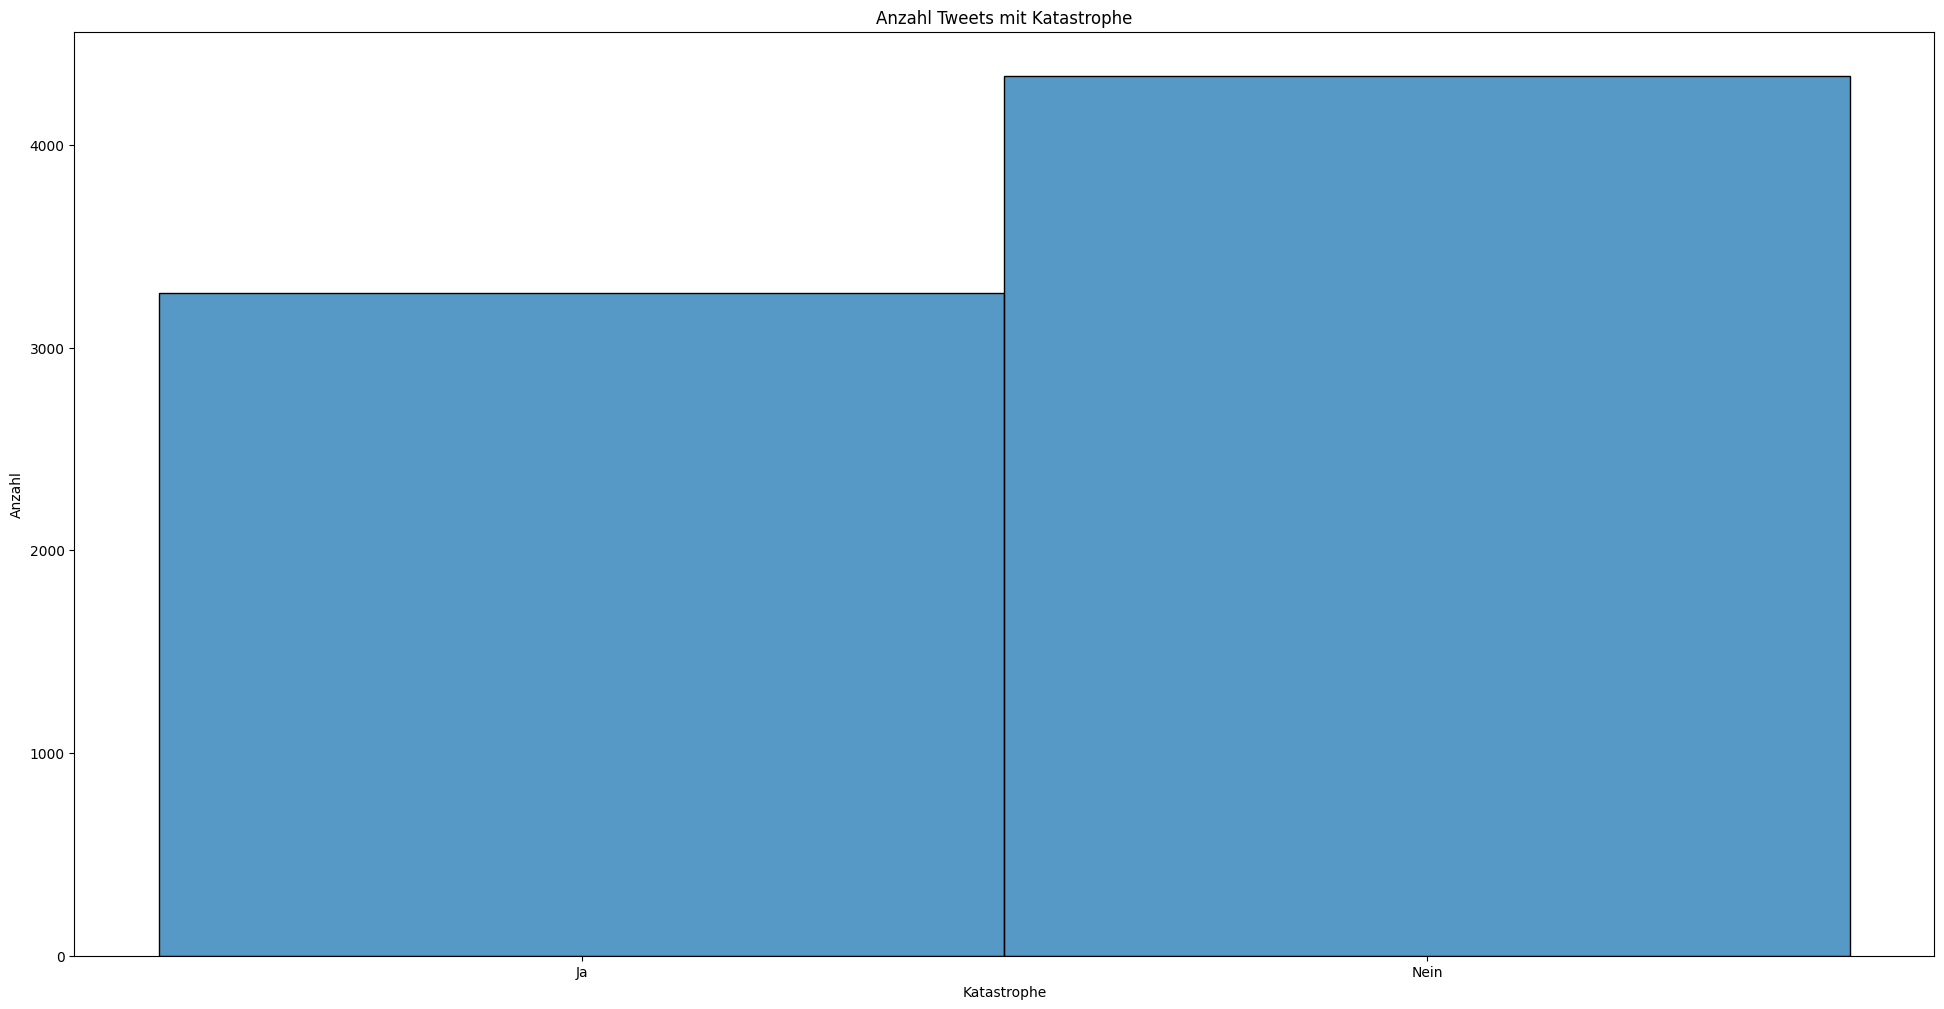

In [10]:
sns.histplot(tweets["target"].replace({0:"Nein",1:"Ja"}))
plt.title("Anzahl Tweets mit Katastrophe")
plt.ylabel("Anzahl")
plt.xlabel("Katastrophe")
plt.show()

Es hat nicht gleiche viele Tweets von beiden Klassen. Dies hat einen Einfluss auf die Metrik, die ausgewählt wird.

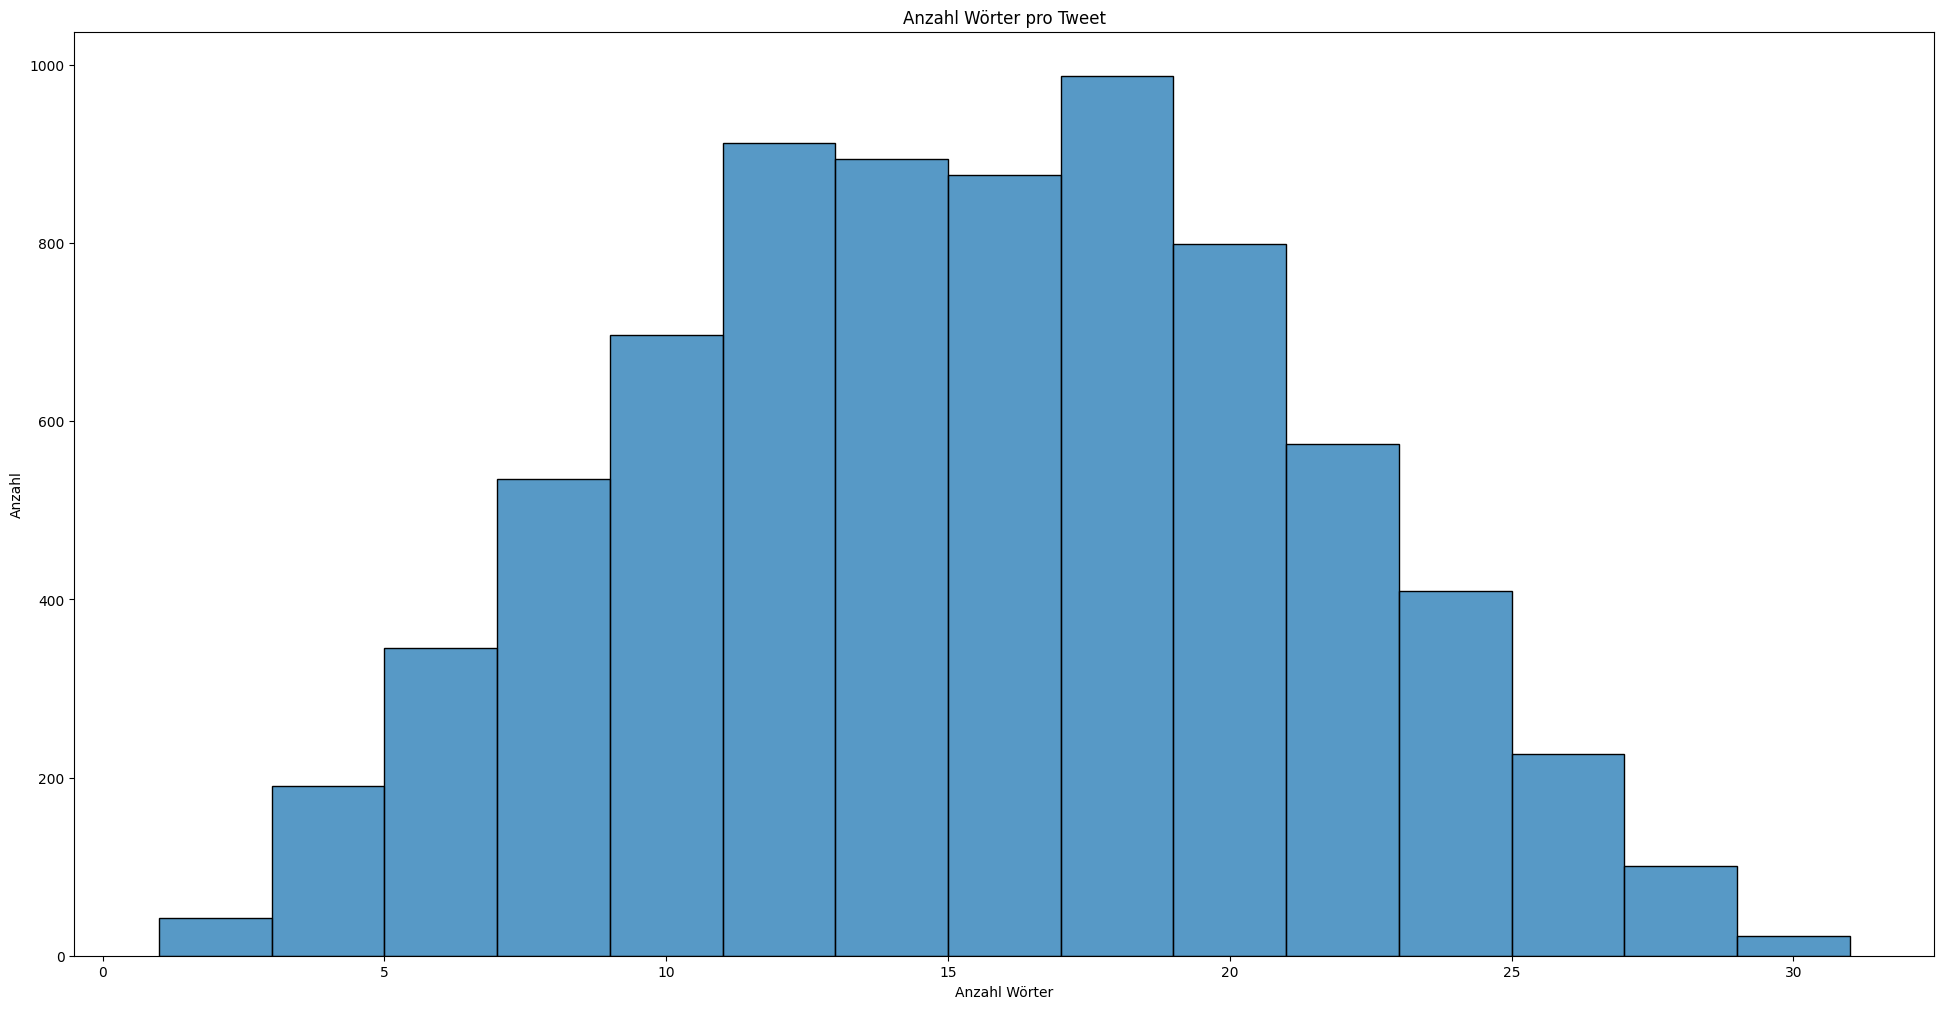

In [11]:
# plot the average number of words per tweet
sns.histplot(tweets["text"].str.split().apply(len), bins=15)
plt.title("Anzahl Wörter pro Tweet")
plt.ylabel("Anzahl")
plt.xlabel("Anzahl Wörter")
plt.show()

Die meisten Tweets haben zwischen 10 und 20 Wörter. Nur die wenigsten haben mehr als 30 Wörter oder weniger als 5 Wörter. Bei kürzeren Tweets könnte das Modell Schwierigkeiten haben.

### TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) ist eine Textanalyse-Technik, die die Bedeutung von Wörtern in einem Dokument anhand ihrer Häufigkeit und Seltenheit in einem Textkorpus ermittelt. Sie wird häufig in Information Retrieval und Text-Mining verwendet.

Hier werden wir die wichtigsten Wörter für Tweets mit Katastrophen und ohne Katastrophen ermitteln. Dies kann uns helfen, die Daten besser zu verstehen und die Modelle zu verbessern.

In [12]:
# quick preprocessing, so we get clean tweets with only words
catastrophe_tweets = [tweet.lower() for tweet in tweets[tweets.target == 1]["text"]]
catastrophe_tweets = ["".join(c for c in tweet if c not in string.punctuation) for tweet in catastrophe_tweets]
catastrophe_tweets = ["".join(c for c in tweet if c not in string.digits) for tweet in catastrophe_tweets]
catastrophe_tweets = [" ".join(tweet.split()) for tweet in catastrophe_tweets]

normal_tweets = [tweet.lower() for tweet in tweets[tweets.target == 0]["text"]]
normal_tweets = ["".join(c for c in tweet if c not in string.punctuation) for tweet in normal_tweets]
normal_tweets = ["".join(c for c in tweet if c not in string.digits) for tweet in normal_tweets]
normal_tweets = [" ".join(tweet.split()) for tweet in normal_tweets]

all_tweets = catastrophe_tweets + normal_tweets

display("Example tweets:")
display(all_tweets[:10])

'Example tweets:'

['our deeds are the reason of this earthquake may allah forgive us all',
 'forest fire near la ronge sask canada',
 'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
 'people receive wildfires evacuation orders in california',
 'just got sent this photo from ruby alaska as smoke from wildfires pours into a school',
 'rockyfire update california hwy closed in both directions due to lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas',
 'im on top of the hill and i can see a fire in the woods',
 'theres an emergency evacuation happening now in the building across the street',
 'im afraid that the tornado is coming to our area']

Hier sehen wir, dass die Tweets korrekt bereinigt wurden.

In [13]:
# Load the english stop words
stop_words_en = (
    pd.read_csv(
        "https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt",
        header=None,
    )
    .iloc[:, 0]
)
stop_words_en = [word for word in stop_words_en if isinstance(word, str)]
stop_words_en = ["".join(c for c in word if c not in string.punctuation) for word in stop_words_en]
stop_words_en = ["".join(c for c in word if c not in string.digits) for word in stop_words_en]

# Create the tfidf matrix
tfidf = TfidfVectorizer(stop_words=stop_words_en)
tfidf_matrix = tfidf.fit_transform(all_tweets)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Results
print(f"Top 10 Catastrophe Tweets Features: \n{tfidf_df.iloc[:len(catastrophe_tweets)].mean().sort_values(ascending=False)[:10]}\n")
print(f"Top 10 Normal Tweets Features: \n{tfidf_df.iloc[len(catastrophe_tweets):].mean().sort_values(ascending=False)[:10]}")

Top 10 Catastrophe Tweets Features: 
news          0.008754
california    0.008483
disaster      0.007901
suicide       0.007677
hiroshima     0.007261
people        0.006959
families      0.006709
fires         0.006705
police        0.006594
killed        0.006548
dtype: float64

Top 10 Normal Tweets Features: 
amp          0.008135
body         0.006131
love         0.005824
time         0.005108
day          0.004920
people       0.004913
video        0.004695
lol          0.004345
youtube      0.004162
emergency    0.003971
dtype: float64


Wir können erkennen, dass negativere Wörter häufig wichtige Wörter für Tweets mit Katastrophen sind. 
Dies ist bei Tweets ohne Katastrophen nicht der Fall.

## Data Preprocessing